In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive


# 데이터 불러오기
file_path = './실습데이터/국민건강보험공단_건강검진정보_20221231.CSV'
data = pd.read_csv(file_path, encoding='cp949')

# 고혈압 라벨링
data['label'] = np.where((data['수축기혈압'] >= 140) & (data['이완기혈압'] >= 90), 1, 0)


# 특성과 라벨 분리
features = ['감마지티피', '연령대코드(5세단위)', '성별', '식전혈당(공복혈당)', '체중(5kg단위)', '허리둘레', '혈청크레아티닌', '혈청지오티(AST)', '혈청지피티(ALT)', '요단백', '혈색소']
numeric_features = ['감마지티피', '연령대코드(5세단위)', '식전혈당(공복혈당)', '체중(5kg단위)', '허리둘레', '혈청크레아티닌', '혈청지오티(AST)', '혈청지피티(ALT)', '요단백', '혈색소']
categorical_features = ['성별']

X = data[features]
y = data['label']

# 수치형 데이터의 결측치를 평균값으로 대체
imputer = SimpleImputer(strategy='mean')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# 범주형 데이터 인코딩
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# 언더샘플링을 사용하여 데이터 불균형 해결
rus = RandomUnderSampler(random_state=30)
X_res, y_res = rus.fit_resample(X, y)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.4, random_state=30)

# 특성 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


<ipython-input-8-9f4c2ab1c328>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_features] = imputer.fit_transform(X[numeric_features])


Model: LogisticRegression
[[14354  7952]
 [ 7454 14674]]
              precision    recall  f1-score   support

           0       0.66      0.64      0.65     22306
           1       0.65      0.66      0.66     22128

    accuracy                           0.65     44434
   macro avg       0.65      0.65      0.65     44434
weighted avg       0.65      0.65      0.65     44434

Predictions: [0 1 1 ... 0 1 0]




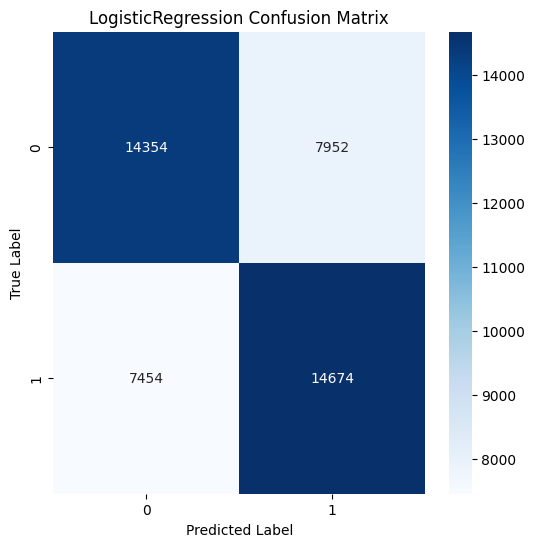

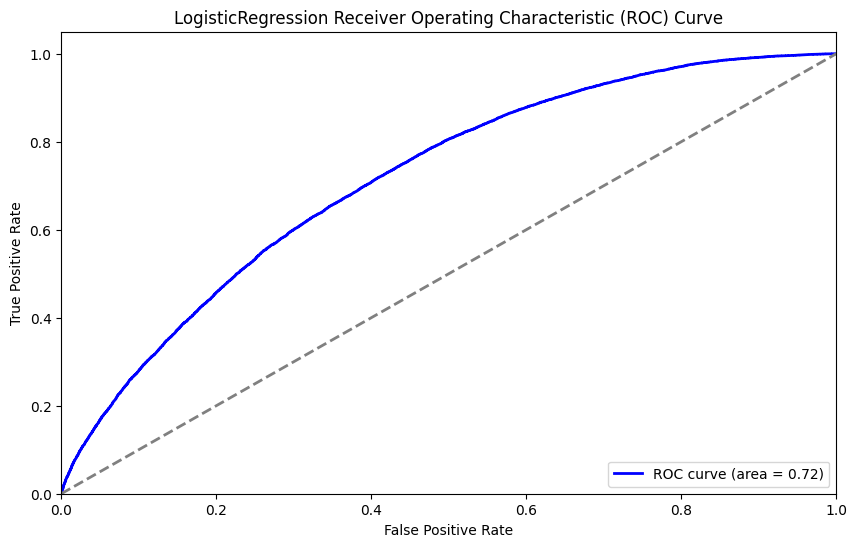

Model: XGBoost
[[13615  8691]
 [ 6430 15698]]
              precision    recall  f1-score   support

           0       0.68      0.61      0.64     22306
           1       0.64      0.71      0.67     22128

    accuracy                           0.66     44434
   macro avg       0.66      0.66      0.66     44434
weighted avg       0.66      0.66      0.66     44434

Predictions: [0 1 1 ... 0 1 0]




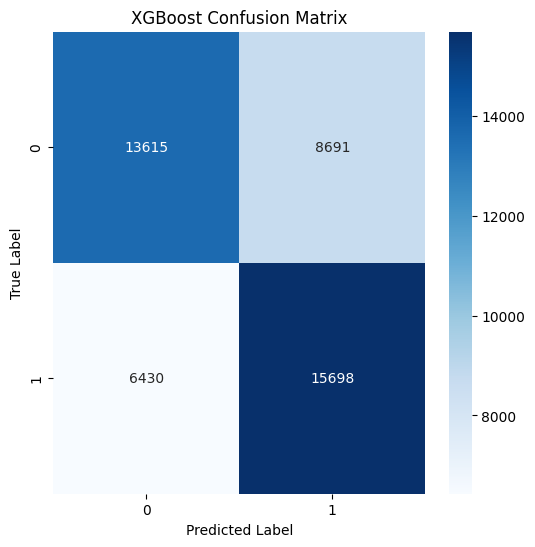

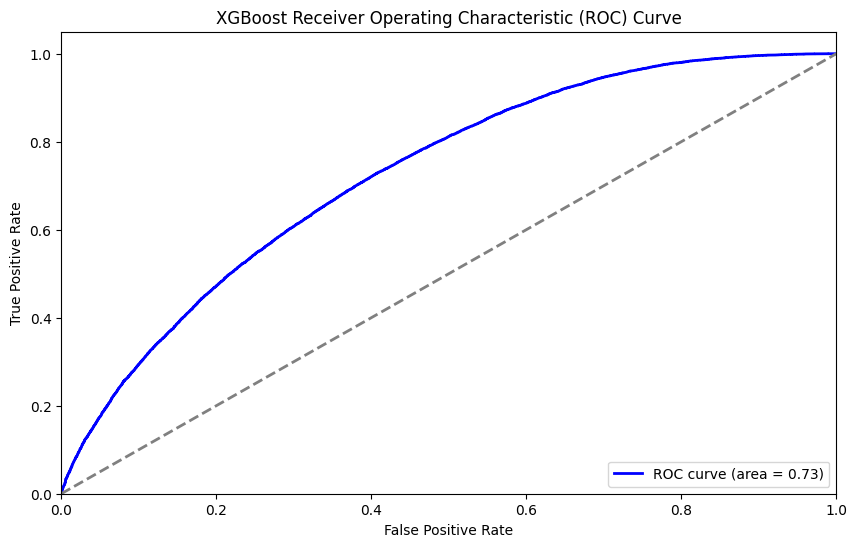

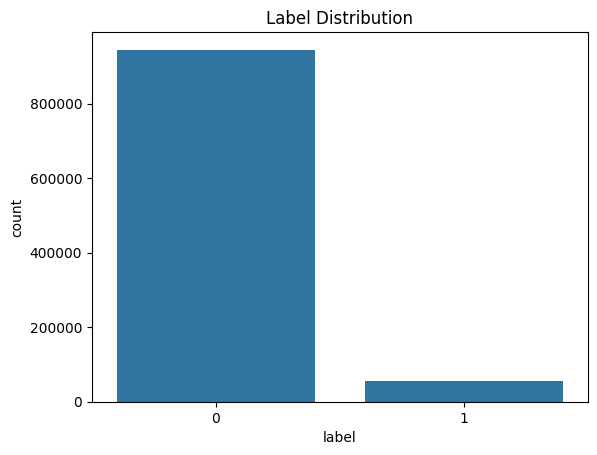

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52629 (\N{HANGUL SYLLABLE CUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54792 (\N{HANGUL SYLLABLE HYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50517 (\N{HANGUL SYLLABLE AB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


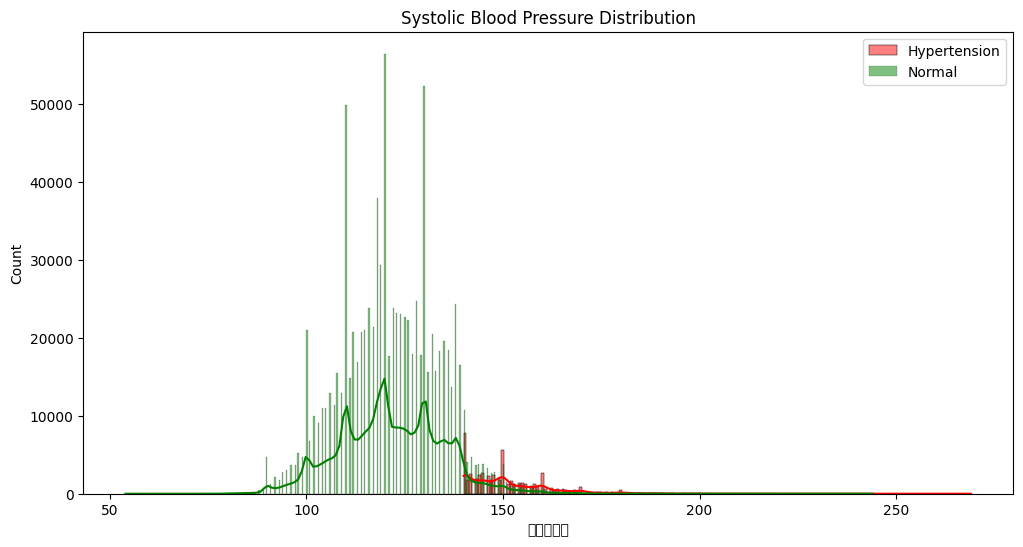

In [14]:
# 모델 사용 및 비교
models = {
    'LogisticRegression': LogisticRegression(random_state=30),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=30)
}

# 모델 학습 및 평가
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # ROC 곡선을 위한 예측 확률
    print(f"Model: {model_name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Predictions:", y_pred)
    print("\n")

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC 곡선 시각화
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# 라벨 분포 시각화
sns.countplot(x='label', data=data)
plt.title('Label Distribution')
plt.show()

# 혈압 및 감마지티피 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(data[data['label'] == 1]['수축기혈압'], kde=True, color='r', label='Hypertension')
sns.histplot(data[data['label'] == 0]['수축기혈압'], kde=True, color='g', label='Normal')
plt.title('Systolic Blood Pressure Distribution')
plt.legend()
plt.show()